In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r'archive/co2_em.csv')
data.head(5)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [3]:
data.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)'],
      dtype='object')

In [4]:
data.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [5]:
correlations = data.corr(numeric_only=True)["CO2 Emissions(g/km)"].sort_values(ascending=False)
print("\nCorrelation with CO2 Emissions:\n", correlations)


Correlation with CO2 Emissions:
 CO2 Emissions(g/km)                 1.000000
Fuel Consumption City (L/100 km)    0.919592
Fuel Consumption Comb (L/100 km)    0.918052
Fuel Consumption Hwy (L/100 km)     0.883536
Engine Size(L)                      0.851145
Cylinders                           0.832644
Fuel Consumption Comb (mpg)        -0.907426
Name: CO2 Emissions(g/km), dtype: float64


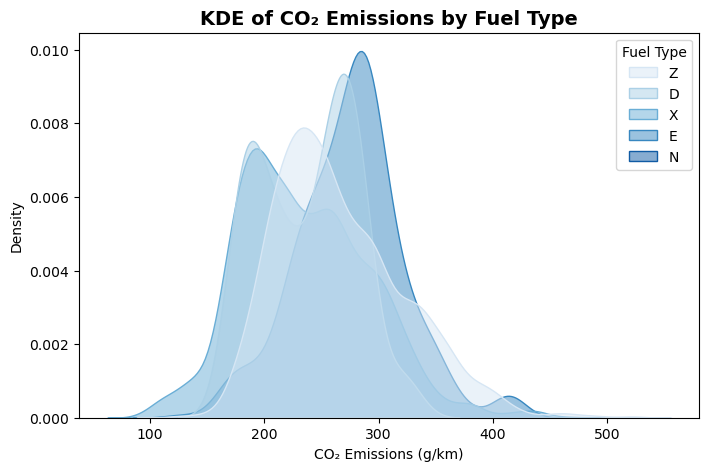

In [6]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=data,
    x="CO2 Emissions(g/km)",
    hue="Fuel Type",  
    fill=True,
    common_norm=False,
    alpha=0.5,
    palette="Blues"
)
plt.title("KDE of CO₂ Emissions by Fuel Type", fontsize=14, fontweight="bold")
plt.xlabel("CO₂ Emissions (g/km)")
plt.ylabel("Density")
plt.show()


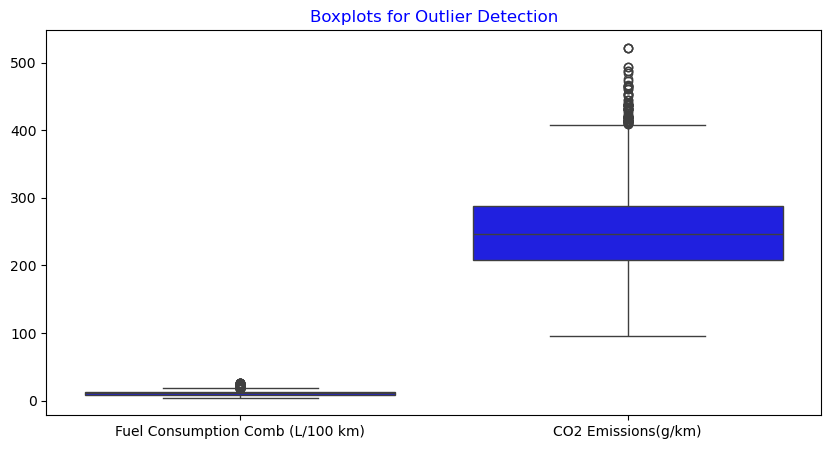

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=data[['Fuel Consumption Comb (L/100 km)', 'CO2 Emissions(g/km)']],
    color="blue" 
)
plt.title("Boxplots for Outlier Detection", color="blue")  
plt.show()


In [8]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

data_clean = remove_outliers_iqr(data, 'Fuel Consumption Comb (L/100 km)')
data_clean = remove_outliers_iqr(data_clean, 'CO2 Emissions(g/km)')

print(f"Original data size: {data.shape[0]}")
print(f"After outlier removal: {data_clean.shape[0]}")

Original data size: 7385
After outlier removal: 7214


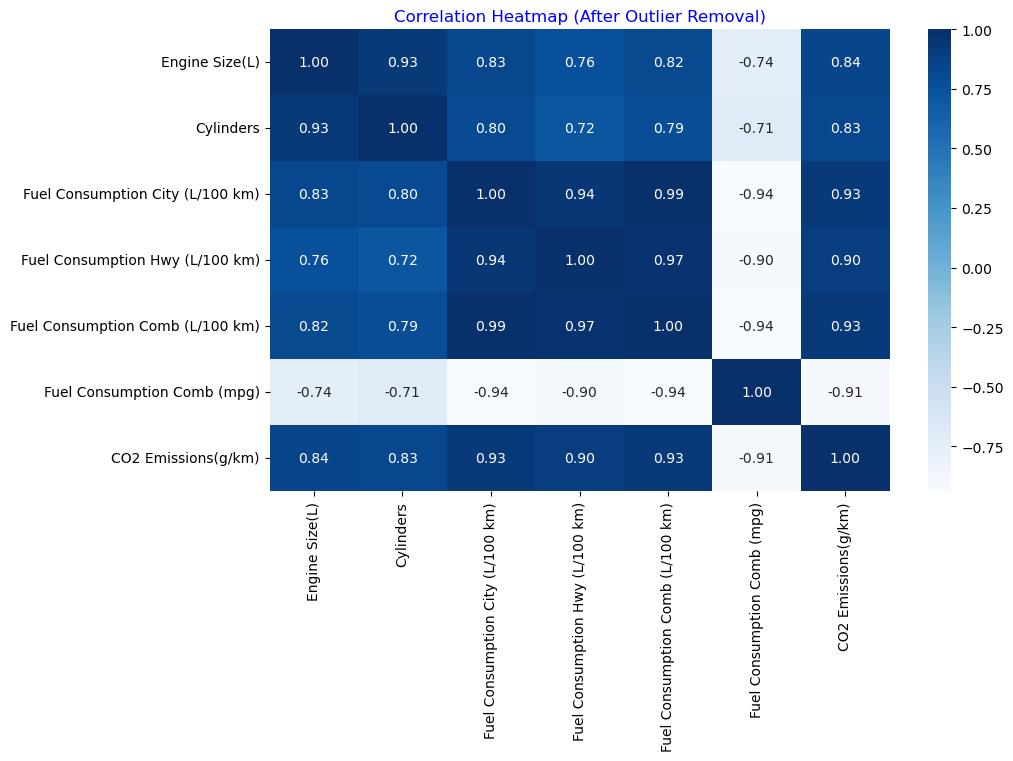

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(
    data_clean.corr(numeric_only=True),
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Correlation Heatmap (After Outlier Removal)", color="blue")
plt.show()

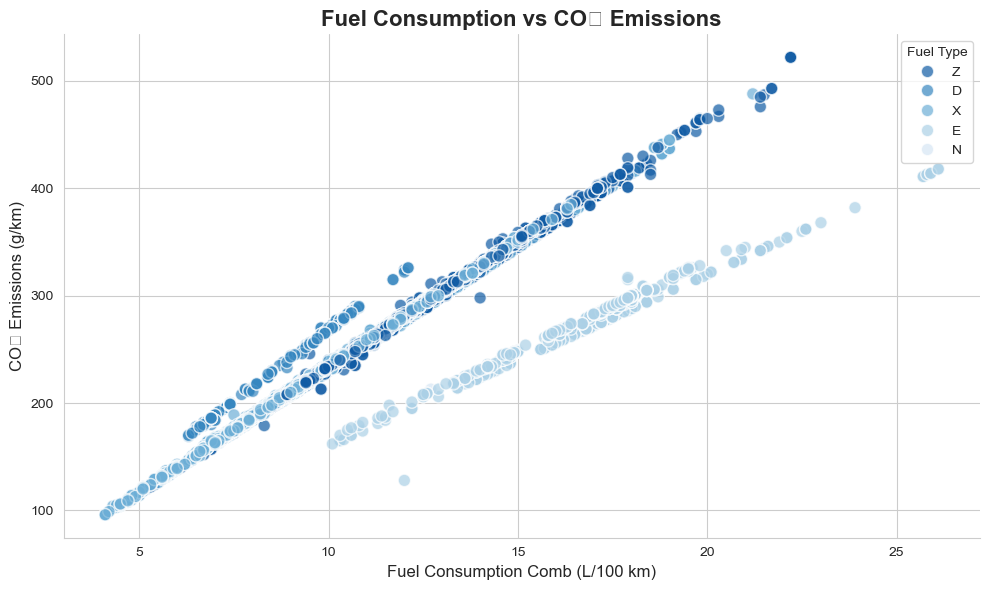

In [10]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    data=data,
    x="Fuel Consumption Comb (L/100 km)",
    y="CO2 Emissions(g/km)",
    hue="Fuel Type",       # color by category for better insight
    palette="Blues_r",
    s=80, alpha=0.7, edgecolor="white", linewidth=1
)

plt.title("Fuel Consumption vs CO₂ Emissions", fontsize=16, fontweight="bold")
plt.xlabel("Fuel Consumption Comb (L/100 km)", fontsize=12)
plt.ylabel("CO₂ Emissions (g/km)", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


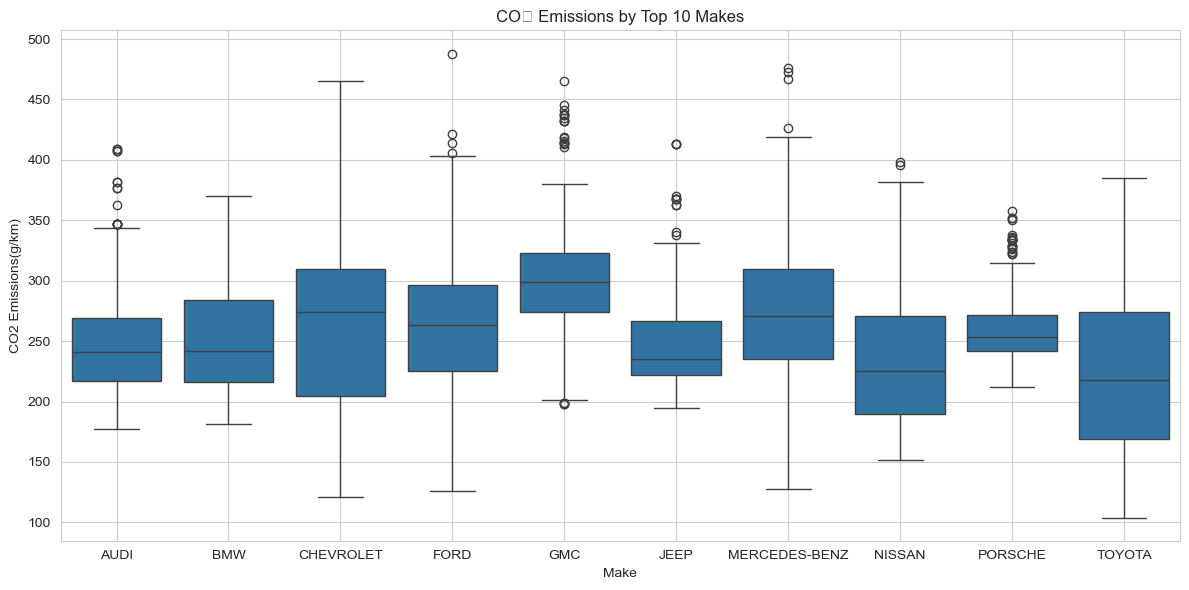

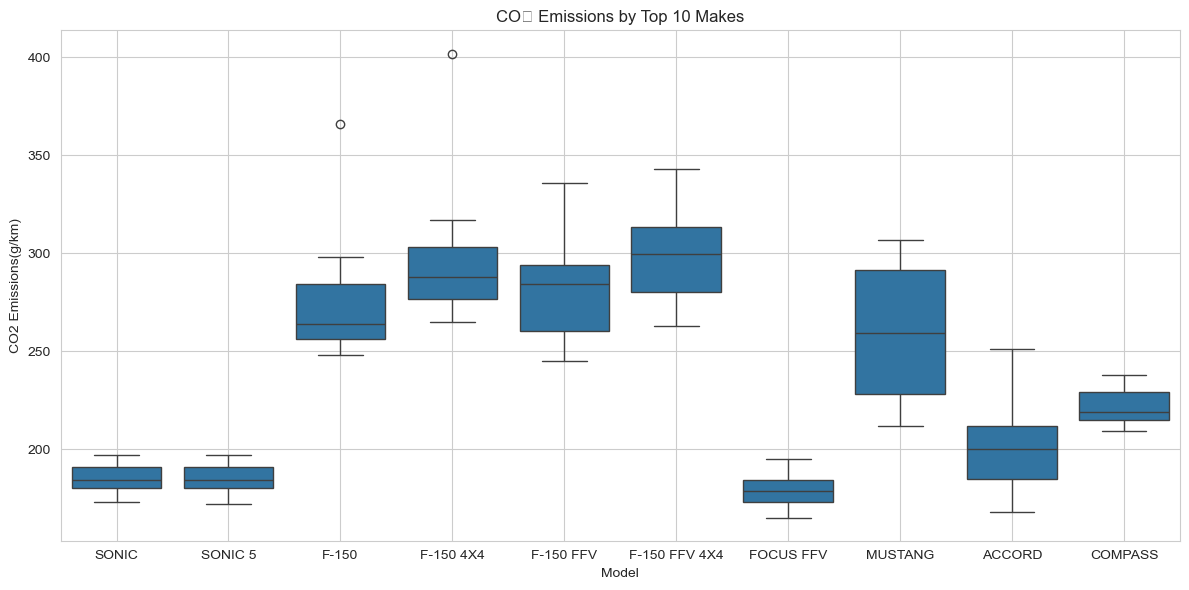

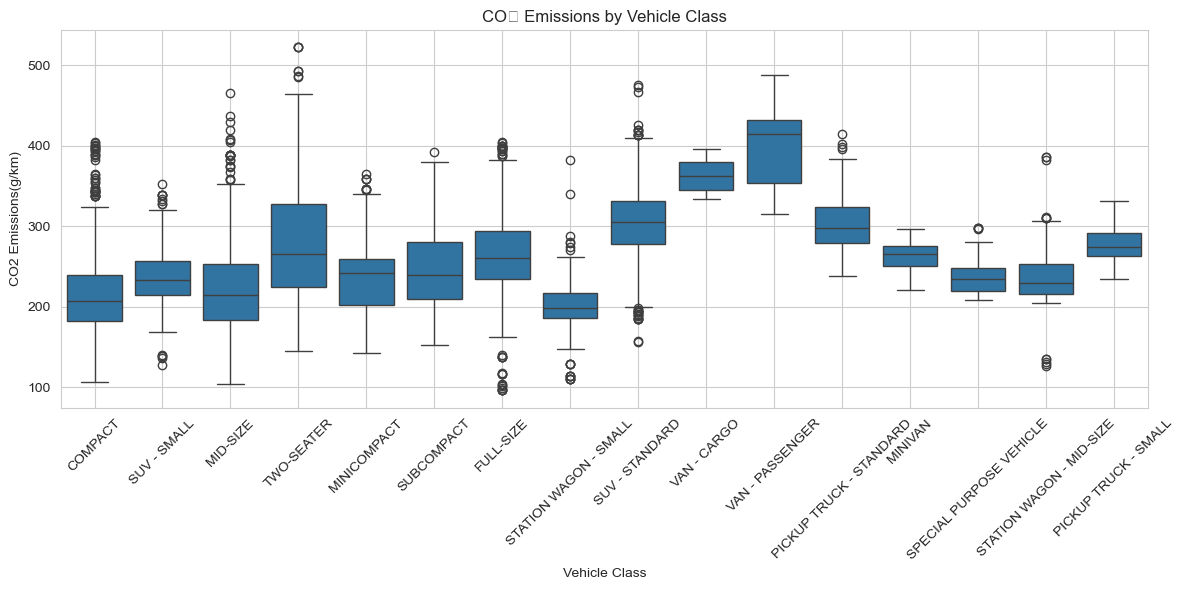

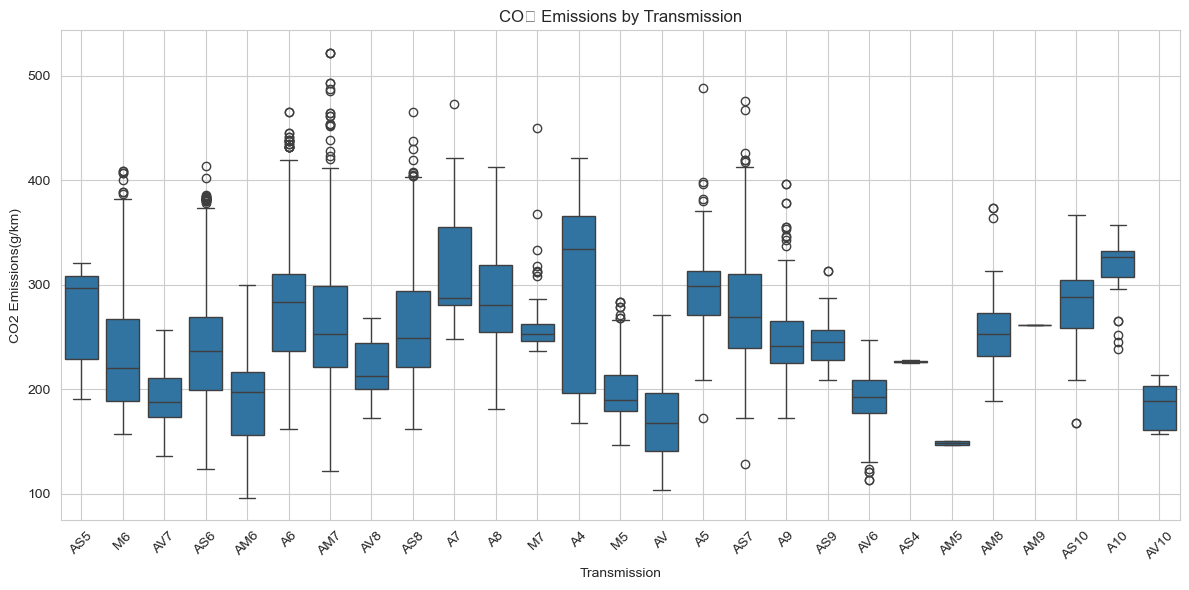

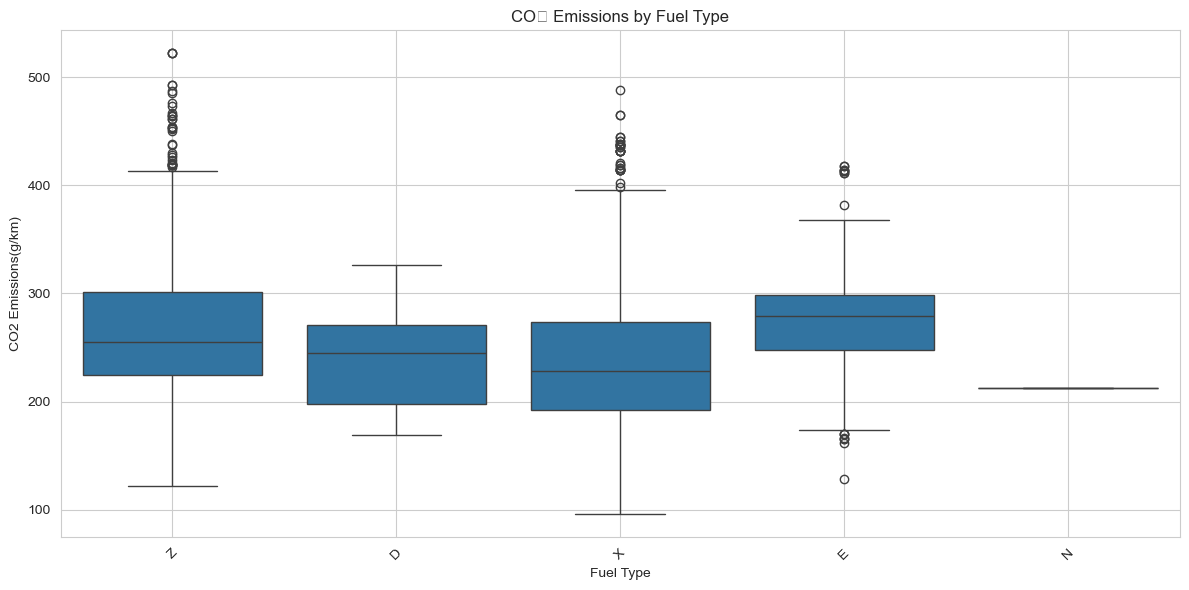

In [11]:
top_makes = data['Make'].value_counts().nlargest(10).index
cars_top_makes = data[data['Make'].isin(top_makes)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=cars_top_makes, x='Make', y='CO2 Emissions(g/km)')
plt.title("CO₂ Emissions by Top 10 Makes")
plt.grid(True)
plt.tight_layout()
plt.show()

# For top 10 Models

top_models = data['Model'].value_counts().nlargest(10).index
cars_top_models = data[data['Model'].isin(top_models)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=cars_top_models, x='Model', y='CO2 Emissions(g/km)')
plt.title("CO₂ Emissions by Top 10 Makes")
plt.grid(True)
plt.tight_layout()
plt.show()


# For rest of categorical columns
categorical_cols = ["Vehicle Class", "Transmission", "Fuel Type"] #except make/model

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x=col, y="CO2 Emissions(g/km)")
    plt.xticks(rotation=45)
    plt.title(f"CO₂ Emissions by {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
target = "CO2 Emissions(g/km)"
X = data.drop(columns=[target, "Model"])
y = data[target]

In [13]:
categorical_features = X.select_dtypes(include="object").columns.tolist()
numeric_features = X.select_dtypes(exclude="object").columns.tolist()

In [14]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)
    ]
)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5),
    "LassoCV": LassoCV(alphas=np.logspace(-3, 3, 7), cv=5, max_iter=10000),
    "HuberRegressor": HuberRegressor(max_iter=1000)
}

In [17]:
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R²": r2
    })

    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")



LinearRegression Performance:
RMSE: 5.09
R²: 0.9925

RidgeCV Performance:
RMSE: 5.10
R²: 0.9924

LassoCV Performance:
RMSE: 5.27
R²: 0.9919

HuberRegressor Performance:
RMSE: 5.30
R²: 0.9918


In [18]:
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

best_model_name = results_df.sort_values(by="R²", ascending=False).iloc[0]["Model"]
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                            ("model", best_model)])
best_pipe.fit(X_train, y_train)

joblib.dump(best_pipe, "best_co2_model.joblib")
results_df.to_csv("model_comparison.csv", index=False)


Model Comparison:
               Model      RMSE        R²
0  LinearRegression  5.090288  0.992467
1           RidgeCV  5.098954  0.992441
2           LassoCV  5.268425  0.991930
3    HuberRegressor  5.303964  0.991821

Best Model: LinearRegression


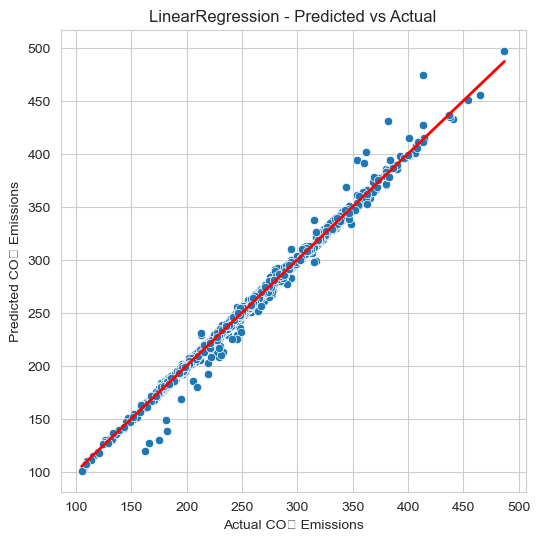

In [19]:
y_pred_best = best_pipe.predict(X_test)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r-', lw=2)
plt.xlabel("Actual CO₂ Emissions")
plt.ylabel("Predicted CO₂ Emissions")
plt.title(f"{best_model_name} - Predicted vs Actual")
plt.show()